## dog_breeds_identification kaggle game

### Preparing

In [1]:
# Put these at the top of every notebook, to get automatic reloading and inline plotting
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [1]:
import torch
from fastai.imports import *
from fastai.transforms import *
from fastai.conv_learner import *
from fastai.model import *
from fastai.dataset import *
from fastai.sgdr import *
from fastai.plots import *


#### gpu not good for cpu mode

In [3]:
torch.cuda.is_available()

True

In [4]:
torch.backends.cudnn.enabled

True

In [5]:
torch.cuda.set_device(0)

### Download from kaggle















In [6]:
#!pip install kaggle
# download your own kaggle.json  put it under ~/.kaggle/
# run kaggle competitions download -c dog-breed-identification
# zip file will locates in ~/kaggle/..

In [7]:
PATH = "data/dogbreeds/"

### Prepare data 


In [14]:
!ls {PATH}

labels.csv  sample_submission.csv  test  train


#### check train set

In [15]:
!pwd

/home/ubuntu/fastai/courses/dl1


In [16]:
label_csv = f'{PATH}labels.csv'
print(label_csv)
#list of rows, minus 1, nubmer of rows in CSV, number of imgs
n = len(list(open(label_csv)))-1
print(n)

data/dogbreeds/labels.csv
10222


In [17]:
labels_df= pd.read_csv(label_csv)
labels_df.head()


,id,breed
0,000bec180eb18c7604dcecc8fe0dba07,boston_bull
1,001513dfcb2ffafc82cccf4d8bbaba97,dingo
2,001cdf01b096e06d78e9e5112d419397,pekinese
3,00214f311d5d2247d5dfe4fe24b2303d,bluetick
4,0021f9ceb3235effd7fcde7f7538ed62,golden_retriever


In [18]:
len(labels_df['breed'].unique())

120

In [19]:
labels_df.pivot_table(index='breed',aggfunc=len).sort_values('id',ascending=False)

,id
breed,
scottish_deerhound,126
maltese_dog,117
afghan_hound,116
entlebucher,115
bernese_mountain_dog,114
shih-tzu,112
great_pyrenees,111
pomeranian,111
basenji,110


#### 20% as validation data

In [22]:
def get_cv_idxs(n, cv_idx=4, val_pct=0.2, seed=1):
    np.random.seed(seed)
    n_val = int(val_pct*n)
    idx_start = cv_idx*n_val
    idxs = np.random.permutation(n)
    return idxs[idx_start:idx_start+n_val]

In [23]:
# get crossvalidation indexes custom FASTAI
val_idxs = get_cv_idxs(n)
print(val_idxs)

[9026 6380 2500 ... 2895 7813  905]


### Train model using FastAi steps

#### some basic set

不同的架构有不同的参数，结构

In [32]:

# arch=resnet34
arch=resnet101
# arch=resnext54
bs=24
sz=224

####  load data enable data agument 

In [33]:
#That's the way of it
tfms = tfms_from_model(arch,sz,aug_tfms=transforms_side_on,max_zoom=1.1)
data = ImageClassifierData.from_csv(PATH,'train',
                                    label_csv,tfms=tfms,
                                    val_idxs=val_idxs,
                                    suffix='.jpg',
                                    test_name='test',
                                    bs =bs)

#### dealing with huge or tiny images

In [34]:
# fn = PATH+data.trn_ds.fnames[0]
fn = PATH + data.val_ds.fnames[0]
fn

'data/dogbreeds/train/001cdf01b096e06d78e9e5112d419397.jpg'

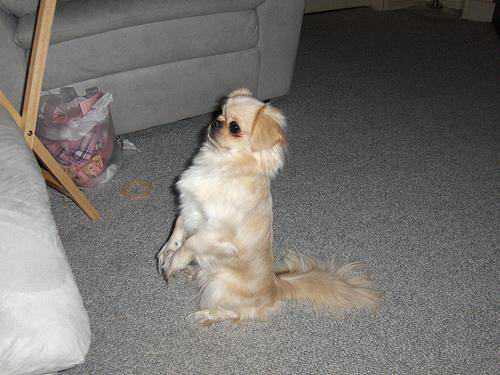

In [35]:
img = PIL.Image.open(fn)
img

In [ ]:
size_d = {k: PIL.Image.open(PATH+k).size for k in data.trn_ds.fnames}

* zip用法
```
>>>a = [1,2,3]
>>> b = [4,5,6]
>>> c = [4,5,6,7,8]
>>> zipped = zip(a,b)     # 打包为元组的列表
[(1, 4), (2, 5), (3, 6)]
>>> zip(a,c)              # 元素个数与最短的列表一致
[(1, 4), (2, 5), (3, 6)]
>>> zip(*zipped)          # 与 zip 相反，可理解为解压，返回二维矩阵式
[(1, 2, 3), (4, 5, 6)]
```

In [48]:
# 行列分开，分别统计
row_sz,col_sz = list(zip(*size_d.values()));

row_sz = np.array(row_sz); col_sz=np.array(col_sz)

(array([3047., 5001.,   84.,   14.,   10.,    4.,   14.,    2.,    0.,    2.]),
 array([  97. ,  413.7,  730.4, 1047.1, 1363.8, 1680.5, 1997.2, 2313.9, 2630.6, 2947.3, 3264. ]),
 <a list of 10 Patch objects>)

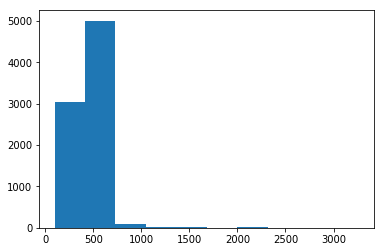

In [49]:
plt.hist(row_sz)

(array([ 19.,  95., 267., 288., 193., 874., 958., 371., 250., 204.]),
 array([ 97. , 137.2, 177.4, 217.6, 257.8, 298. , 338.2, 378.4, 418.6, 458.8, 499. ]),
 <a list of 10 Patch objects>)

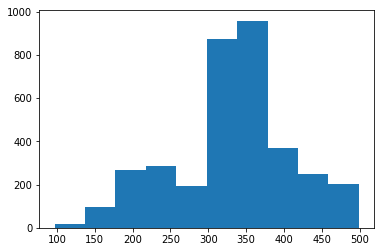

In [50]:
plt.hist(row_sz[row_sz < 500])

(array([2889., 5106.,  118.,   21.,   15.,   16.,    7.,    3.,    0.,    3.]),
 array([ 102.,  348.,  594.,  840., 1086., 1332., 1578., 1824., 2070., 2316., 2562.]),
 <a list of 10 Patch objects>)

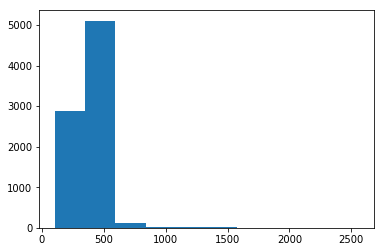

In [51]:
plt.hist(col_sz)

In [52]:
len(data.trn_ds),len(data.val_ds)

(8178, 2044)

In [53]:
data.classes[:5]

['affenpinscher',
 'afghan_hound',
 'african_hunting_dog',
 'airedale',
 'american_staffordshire_terrier']

In [54]:
# 输入sz和batch sz为参数，可以调整不同大小数据的训练结果
def get_data(sz,bs):
    tfms = tfms_from_model(arch,sz,aug_tfms=transforms_side_on,max_zoom=1.1)
    data = ImageClassifierData.from_csv(PATH,'train',
                                    label_csv,tfms=tfms,
                                    val_idxs=val_idxs,
                                    suffix='.jpg',
                                    test_name='test',
                                    bs =bs)
    return data if (sz > 300) else data.resize(340,'tmp')
    

#### learn a right learning rate using lr_find     

In [55]:
# 先训练224
bs=24
sz=224
data = get_data(sz,bs);

In [56]:
learn = ConvLearner.pretrained(arch, data, precompute=True)

Downloading: "https://download.pytorch.org/models/resnet101-5d3b4d8f.pth" to /home/ubuntu/.torch/models/resnet101-5d3b4d8f.pth
100%|██████████| 178728960/178728960 [00:02<00:00, 68625635.68it/s]


100%|██████████| 432/432 [02:34<00:00,  2.80it/s]


 83%|████████▎ | 284/341 [00:14<00:02, 19.05it/s, loss=9.66]

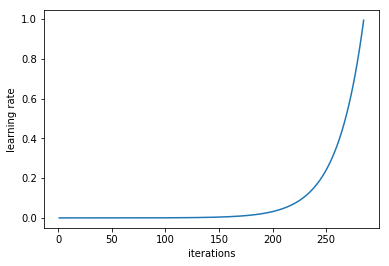

In [57]:
learn.lr_find()
# plot lr and iterations
learn.sched.plot_lr()

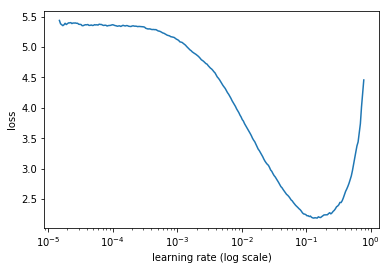

In [58]:
#plot lost function and lr ,thus find the best lr
learn.sched.plot()

In [59]:
suitable_lr = 0.01;

 83%|████████▎ | 284/341 [00:30<00:06,  9.47it/s, loss=9.66]

#### pre-train last layer 1-2 epochs 
precomputed=True
Try small size data set first!

In [60]:
learn = ConvLearner.pretrained(arch, data, precompute=True)
learn.fit(suitable_lr, 2)

epoch      trn_loss   val_loss   accuracy                    
    0      0.709949   0.442442   0.868885  
 75%|███████▍  | 255/341 [00:03<00:01, 74.82it/s, loss=0.492]
    1      0.451829   0.410725   0.872798                    



[array([0.41073]), 0.8727984370084192]

#### using SGDR (restart) retrain last layer 

In [61]:
learn.precompute=False
learn.fit(suitable_lr, 3, cycle_len=1)

epoch      trn_loss   val_loss   accuracy                    
    0      0.420168   0.350067   0.893346  
    1      0.422      0.353739   0.8909                      
    2      0.384243   0.349893   0.889432                    



[array([0.34989]), 0.8894324864893277]

In [62]:
learn.save('dogbreeds_224_1st')

#### check point if  sth wrong can restart here

In [63]:
learn.load('dogbreeds_224_1st')

#### check result 1st time

In [64]:
log_preds = learn.predict()

preds = np.argmax(log_preds, axis=1)  # from log probabilities to 0 or 1
probs = np.exp(log_preds[:,1])        # pr(dog)
# probs = np.exp(log_preds)
probs



array([0.     , 0.00048, 0.00024, ..., 0.     , 0.00048, 0.00006], dtype=float32)

####  lr_find again

 74%|███████▎  | 251/341 [01:34<00:33,  2.66it/s, loss=1.12] 

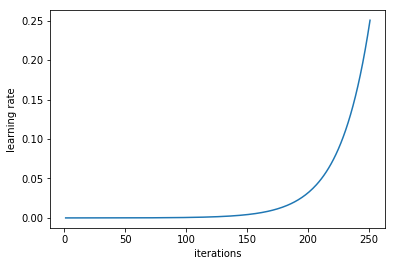

In [65]:

learn.lr_find()
# plot lr and iterations
learn.sched.plot_lr()

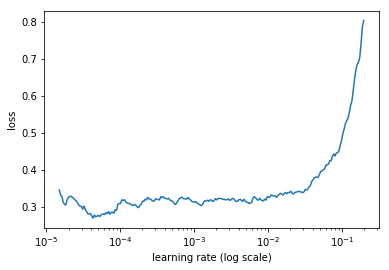

In [66]:
learn.sched.plot()

In [ ]:
#### conlusion

上面看loss并没有改进的余地了?

In [67]:
suitable_lr = 0.01

#### unfreeze and set muti-learning rate for other layer

In [76]:
learn.load('dogbreeds_224_1st')
learn.unfreeze()
lr=np.array([suitable_lr/100,suitable_lr/10,suitable_lr]);
learn.fit(lr, 1, cycle_len=1)

A Jupyter Widget

epoch      trn_loss   val_loss   accuracy                    
    0      0.76473    0.555561   0.829256  



[array([ 0.55556]), 0.82925635914513274]

In [ ]:
learn.save('dogbreeds_224_2nd_more_bad')
#### Decide not using this way

#### Train huge size image data set then!

In [69]:
learn.load('dogbreeds_224_1st')
sz = 299
bs = 48;
learn.set_data(get_data(sz,bs))
learn.fit(suitable_lr,2,cycle_len=1)
# overfit?
#learn.fit(1e-2,3 cycle_len=1, cycle_mult=2)

  0%|          | 0/171 [00:00<?, ?it/s]
epoch      trn_loss   val_loss   accuracy                    
    0      0.308072   0.314278   0.902642  
    1      0.303592   0.313066   0.904599                    



[array([0.31307]), 0.90459882128262]

#### TTA operation for validation set

TTA is kind of better predictiton. 
Prediction for valid dataset aparted from train set (20% of it)

In [70]:
log_preds,y = learn.TTA()
probs = np.mean(np.exp(log_preds),0)
accuracy_np(probs, y)

0.9094911937377691

In [71]:
log_preds.shape

(5, 2044, 120)

In [72]:
learn.save('dogbreeds_224_2nd_good')

### Submit results

#### Predict on test set

In [94]:
fn = data.test_ds.fnames[:]
ids =[f.split(r'/')[1].split('.')[0] for f in fn];

['fd1a7be32f10493735555e62913c0841',
 '5273d42f02b4715cb93845205995ef64',
 '442057a3142f4d75a1023db363e2fb54',
 'fb03302b030afd122e0f4936c158f6c1',
 '511ca6e3539192aa5c8747bb697e0525',
 '2e60533a26e589f57fff34711c5ba73c',
 '27e4bd954bfe78f9e01338dc5108fadd',
 '591566259cbc95dd43b75d77b00aa7a5',
 'a51c2803972dff8c7fcc17f6b7eda64d',
 '9ace4c5cced4fb88678a5b0a9b3f3cf1',
 '0a4ef19459cd2100977b052de5f46231',
 'd1d5b398aaee58ef3d6d7cde20cf17ac',
 '5f93b0c2f5941449705b44ac56555740',
 'a8c328b54ad54952071ca471aaaf9bf8',
 '7b5f0257ec767a039aaf95246561163b',
 '01d5ffa4de01074483149bec0f6e5a59',
 'e12e6997c15c233c7b92209e08ff9d14',
 'b79c8019e5558042de2fd1105defec28',
 'cca524a4ee4fbbea4a867767377f2035',
 '873c14fc563d7d83e6de1253ab6ab67f',
 '99b7f212ca1c54282f01dfb98efbaea3',
 'cb7c8ef5b03d79feb9cf5416836ccc2d',
 '482051c1436a506f7556625e612060a5',
 '7b3ffac7ead20a7062d917ad210e6b08',
 'f9e23db817511ad879ddee9edccebfe7',
 'a0c6b0725c21647464fc786ff9608b65',
 '7f94beaceeeea537472e656c73bc99c1',
 

In [74]:
learn.load('dogbreeds_224_2nd_good')

In [75]:
log_preds = learn.predict(is_test=True)

In [76]:
log_preds.shape

(10357, 120)

In [79]:
probs = np.exp(log_preds)
probs
probs.shape

(10357, 120)

In [80]:
#### gen submission file
sub_df = pd.read_csv(f'{PATH}sample_submission.csv')
sub_df.head()

,id,affenpinscher,afghan_hound,african_hunting_dog,airedale,american_staffordshire_terrier,appenzeller,australian_terrier,basenji,basset,...,toy_poodle,toy_terrier,vizsla,walker_hound,weimaraner,welsh_springer_spaniel,west_highland_white_terrier,whippet,wire-haired_fox_terrier,yorkshire_terrier
0,000621fb3cbb32d8935728e48679680e,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,...,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333
1,00102ee9d8eb90812350685311fe5890,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,...,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333
2,0012a730dfa437f5f3613fb75efcd4ce,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,...,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333
3,001510bc8570bbeee98c8d80c8a95ec1,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,...,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333
4,001a5f3114548acdefa3d4da05474c2e,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,...,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333


In [81]:
sub_df.shape

(10357, 121)

In [85]:
probs_1 = np.zeros(probs.shape);

for i in range(len(ids)):
    idx = np.where(np.array(ids) == sub_df.loc[i,'id'])
    idx = idx[0][0]
    probs_1[i] = probs[i]
    i = i+1

probs_1.shape



(10357, 120)

In [86]:
column_lists = sub_df.columns.tolist()
len(column_lists)

121

In [87]:
result_df = pd.DataFrame(data=probs_1)
result_df.shape

(10357, 120)

#### must re order to submit correctly

In [89]:
results = pd.concat([sub_df['id'],result_df],axis=1);
results.columns = column_lists
results.shape
results.head()

,id,affenpinscher,afghan_hound,african_hunting_dog,airedale,american_staffordshire_terrier,appenzeller,australian_terrier,basenji,basset,...,toy_poodle,toy_terrier,vizsla,walker_hound,weimaraner,welsh_springer_spaniel,west_highland_white_terrier,whippet,wire-haired_fox_terrier,yorkshire_terrier
0,000621fb3cbb32d8935728e48679680e,1.466378e-07,4.218020e-05,5.612704e-08,2.037965e-06,4.681564e-08,6.860812e-10,3.100104e-07,1.061332e-08,2.437208e-07,...,7.098815e-05,2.320869e-08,6.359781e-07,8.591200e-10,7.011459e-08,1.100864e-08,4.693883e-09,2.104961e-08,4.380369e-07,1.183549e-08
1,00102ee9d8eb90812350685311fe5890,3.051790e-06,1.970722e-06,5.676856e-06,4.218840e-05,4.346770e-07,1.737860e-07,7.060091e-08,1.271455e-07,3.393017e-06,...,5.340399e-08,1.668954e-08,2.606714e-06,2.175117e-06,5.970415e-06,4.243705e-07,4.714965e-07,1.627142e-05,1.677192e-05,3.383854e-07
2,0012a730dfa437f5f3613fb75efcd4ce,5.983956e-07,1.518265e-05,2.347699e-07,1.415529e-06,1.728936e-06,1.482218e-05,3.091321e-07,7.670000e-07,9.619170e-05,...,3.317003e-07,3.521933e-06,6.427006e-06,1.630764e-03,1.436473e-05,8.072730e-07,5.077055e-07,6.394374e-07,2.035226e-07,1.386533e-07
3,001510bc8570bbeee98c8d80c8a95ec1,2.331645e-03,7.932706e-06,7.108343e-06,1.865121e-06,1.610537e-05,3.785919e-07,1.087746e-04,2.807767e-06,2.711915e-05,...,4.296474e-03,3.403944e-05,4.107603e-06,4.432040e-06,5.633060e-06,2.490404e-06,7.066171e-05,1.097232e-05,5.081657e-07,5.334602e-03
4,001a5f3114548acdefa3d4da05474c2e,4.076669e-09,2.508298e-09,8.170144e-08,4.072108e-09,4.917470e-08,1.276937e-09,2.709480e-07,1.856335e-09,1.634453e-08,...,2.635692e-06,4.900579e-08,4.617304e-09,9.199391e-11,1.327329e-08,9.024278e-08,3.693846e-06,2.413759e-08,9.954711e-08,1.436436e-07


#### another way more simpler

In [101]:

results =pd.DataFrame(probs_1);
results.columns = column_lists[1:]
results.index = ids;
results.index.name = 'id';
results['id'] = results.index
idi = results.pop('id');

results.insert(0,'id',idi)

results.head()
results.shape


(10357, 121)

#### submit

In [102]:
results.to_csv("fastai_resnet101.csv",index = False);

In [103]:
#### submit
!kaggle competitions submit -c dog-breed-identification -f  "fastai_resnet101.csv" -m "1st resnet34-based result"

Successfully submitted to Dog Breed Identification

### Imporve model

1. 鉴于0.44的得分有点低..可能是模型resnet34的原因?

在第2次学习lr时，看到loss并没有随着学习率发生大的变化.

unfreeze效果也并不好，我也skip掉了.

但是cv的准确率有87%，不应该得分这么低...

(http://files.fast.ai/models/weights.tgz) 下载到fastai 的weight 下，可以添加更多的模型如resnet101_64


`https://download.pytorch.org/models/resnet101-5d3b4d8f.pth" to /home/ubuntu/.torch/models/resnet101-5d3b4d8f.pth`


    
2. 为了提交，按submision的id顺序调整了prob矩阵,可能调整方式不对? 

#### updated 5.21 

使用resnet101 0.31 貌似没有提高多少